# Task 3: Multi-class image classification

Essam Gouda (Individual), 1583772 (egouda)

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications import VGG19, ResNet50, ResNet152V2 #For Transfer Learning

from __future__ import absolute_import, division, print_function, unicode_literals


from tensorboard.plugins.hparams import api as hp


import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white bg for sns plots
sns.set(style="whitegrid", color_codes=True)

from sklearn.model_selection import GridSearchCV


import warnings; warnings.simplefilter('ignore')

import numpy as np

DATASET_PATH = "images/images"
SEED_NO = 123 #fixed seed number for reproducing the same results.
np.random.seed(SEED_NO)

## Dataset

Dataset was used using the "image.zip" file provided on eclass, then it was split into 80% testing and 20% validation.

In [2]:
image_size = (224, 224)
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED_NO,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED_NO,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2084 files belonging to 21 classes.
Using 1668 files for training.
Found 2084 files belonging to 21 classes.
Using 416 files for validation.


Samples from the dataset

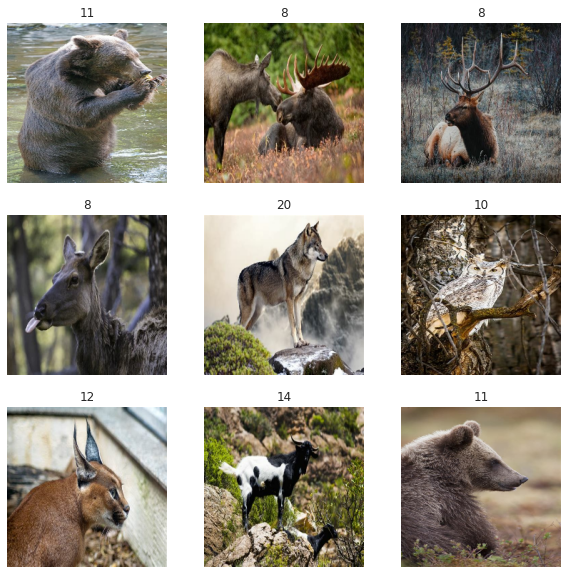

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Data Augmentation

Multiple augmentation methods were used such as flipping, rotating and zooming. More could be added if needed to the pipeline.

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", seed=SEED_NO),
        layers.experimental.preprocessing.RandomRotation(0.1, seed=SEED_NO),
        #tf.keras.layers.experimental.preprocessing.RandomContrast(0.1, seed=SEED_NO),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.1, seed=SEED_NO)
        
    ]
)

Visualizing samples from the augmented data.

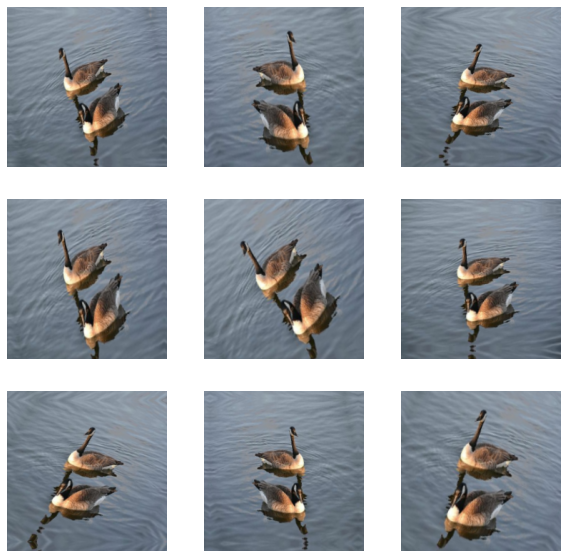

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Initalizing tensorboard

In [7]:
%load_ext tensorboard

In [8]:
#!rm -rf ./logs/hparam_tuning

## Base model without tuning
Base model used ResNet50 without any hyperparameter tuning to check the results.

In [9]:
input_shape = (224, 224, 3)
num_classes = 21


def create_base_model():
    
    base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape, pooling='avg')

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)  # Apply random data augmentation


    x = base_model(x, training=False)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(
                  loss='sparse_categorical_crossentropy', 
                  metrics=['acc'],
                  optimizer=optimizer
             )
    
    return model

#model.summary()

In [10]:
model = create_base_model()
history = model.fit(train_ds,epochs=50,validation_data=val_ds)

Epoch 1/50
14/14 [==============================] - 12s 607ms/step - loss: 3.4324 - acc: 0.0546 - val_loss: 2.7539 - val_acc: 0.1899
Epoch 2/50
14/14 [==============================] - 8s 504ms/step - loss: 2.6349 - acc: 0.2090 - val_loss: 2.1766 - val_acc: 0.3942
Epoch 3/50
14/14 [==============================] - 8s 522ms/step - loss: 2.1524 - acc: 0.3830 - val_loss: 1.8533 - val_acc: 0.4832
Epoch 4/50
14/14 [==============================] - 8s 513ms/step - loss: 1.8224 - acc: 0.4763 - val_loss: 1.5997 - val_acc: 0.5288
Epoch 5/50
14/14 [==============================] - 8s 510ms/step - loss: 1.5891 - acc: 0.5641 - val_loss: 1.4414 - val_acc: 0.5913
Epoch 6/50
14/14 [==============================] - 8s 516ms/step - loss: 1.4415 - acc: 0.6068 - val_loss: 1.3134 - val_acc: 0.6202
Epoch 7/50
14/14 [==============================] - 8s 510ms/step - loss: 1.2942 - acc: 0.6403 - val_loss: 1.2263 - val_acc: 0.6202
Epoch 8/50
14/14 [==============================] - 8s 516ms/step - loss: 1

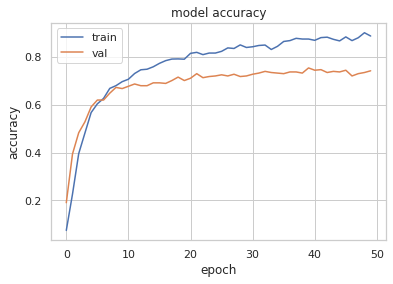

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

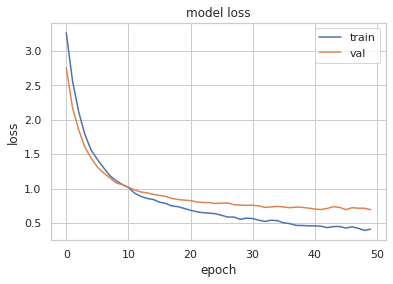

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [13]:
# Evaluating model on validation data
evaluate = model.evaluate(val_ds)
print(evaluate)

4/4 [==============================] - 2s 267ms/step - loss: 0.6915 - acc: 0.7428
[0.6915473341941833, 0.7427884340286255]


In [14]:
from sklearn.metrics import confusion_matrix


y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred,axis=1)
y_true = tf.concat([y for x, y in val_ds], axis=0)
con_mat = confusion_matrix(y_true, y_pred)

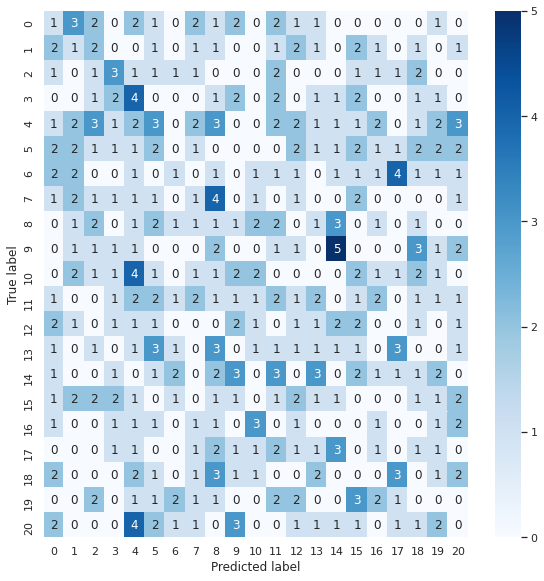

In [15]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Hyperparameter tuning
The base model showed low accuracy and that could occur due to the lack of extra dense layers and no hyperparamter tuning was tested during the constructing of the base model. In this section we add more hidden dense layers for the transfer learning layers and apply hyperparameter tuning to reach better validation accuracy.

NOTE: THIS PART TAKES LONG TIME TO RUN AND TEST (this can be ignored as the final results and model will be trained on the chosen params later), the results of this part could be checked using the logs provided for tensorboard directly.

In [16]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([1024])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([512]))
HP_NUM_UNITS3 = hp.HParam('num_units 3', hp.Discrete([256]))
HP_NUM_UNITS4 = hp.HParam('num_units 4', hp.Discrete([128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_ACTIVATION = hp.HParam('activation func', hp.Discrete(['relu', 'gelu','selu']))
METRIC_ACCURACY = 'accuracy'


with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_NUM_UNITS3, HP_NUM_UNITS4, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER, HP_ACTIVATION],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [17]:
input_shape = (224, 224, 3)
num_classes = 21


def create_model(hparams):
    
    base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape, pooling='avg')



    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)  # Apply random data augmentation


    x = base_model(x, training=False)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(hparams[HP_NUM_UNITS1], activation=hparams[HP_ACTIVATION], input_dim=512)(x)
    x = keras.layers.Dropout(hparams[HP_DROPOUT])(x)  # Regularize with dropout
    x = keras.layers.Dense(hparams[HP_NUM_UNITS2], activation=hparams[HP_ACTIVATION], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]))(x)
    x = keras.layers.Dropout(hparams[HP_DROPOUT])(x)  # Regularize with dropout
    x = keras.layers.Dense(hparams[HP_NUM_UNITS3], activation=hparams[HP_ACTIVATION], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]))(x)
    x = keras.layers.Dropout(hparams[HP_DROPOUT])(x)  # Regularize with dropout
    x = keras.layers.Dense(hparams[HP_NUM_UNITS4], activation=hparams[HP_ACTIVATION])(x)
    x = keras.layers.Dropout(hparams[HP_DROPOUT])(x)  # Regularize with dropout
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(
                  loss='sparse_categorical_crossentropy', 
                  metrics=['acc'],
                  optimizer=hparams[HP_OPTIMIZER]
             )
    
    model.fit(train_ds, validation_data=val_ds, epochs=50)
    _, accuracy = model.evaluate(val_ds)
    return accuracy

In [18]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = create_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [19]:
session_num = 0
for num_units1 in HP_NUM_UNITS1.domain.values:
  for num_units2 in HP_NUM_UNITS2.domain.values:
      for num_units3 in HP_NUM_UNITS3.domain.values:
          for num_units4 in HP_NUM_UNITS4.domain.values:
            for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
              for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    for act in HP_ACTIVATION.domain.values:
                    

                      hparams = {
                          HP_NUM_UNITS1: num_units1,
                          HP_NUM_UNITS2: num_units2,
                          HP_NUM_UNITS3: num_units3,
                          HP_NUM_UNITS4: num_units4,
                          HP_DROPOUT: dropout_rate,
                          HP_L2: l2,
                          HP_OPTIMIZER: optimizer,
                          HP_ACTIVATION: act

                      }
                      run_name = "run-%d" % session_num
                      print('--- Starting trial: %s' % run_name)
                      print({h.name: hparams[h] for h in hparams})
                      run('logs/hparam_tuning/' + run_name, hparams)
                      session_num += 1

--- Starting trial: run-0
{'num_units 1': 1024, 'num_units 2': 512, 'num_units 3': 256, 'num_units 4': 128, 'dropout': 0.2, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop', 'activation func': 'gelu'}
Epoch 1/50
14/14 [==============================] - 11s 564ms/step - loss: 4.6139 - acc: 0.0833 - val_loss: 3.5313 - val_acc: 0.1923
Epoch 2/50
14/14 [==============================] - 8s 509ms/step - loss: 3.3191 - acc: 0.2653 - val_loss: 3.2128 - val_acc: 0.3101
Epoch 3/50
14/14 [==============================] - 8s 544ms/step - loss: 2.9238 - acc: 0.3530 - val_loss: 3.2523 - val_acc: 0.3534
Epoch 4/50
14/14 [==============================] - 8s 523ms/step - loss: 2.5633 - acc: 0.4348 - val_loss: 3.0027 - val_acc: 0.4207
Epoch 5/50
14/14 [==============================] - 8s 501ms/step - loss: 2.3252 - acc: 0.5153 - val_loss: 2.2644 - val_acc: 0.5529
Epoch 6/50
14/14 [==============================] - 8s 502ms/step - loss: 1.8852 - acc: 0.5970 - val_loss: 2.8849 - val_acc: 0.4808
Epoch 7

14/14 [==============================] - 9s 548ms/step - loss: 1.7546 - acc: 0.5999 - val_loss: 2.3338 - val_acc: 0.5096
Epoch 10/50
14/14 [==============================] - 9s 541ms/step - loss: 1.7556 - acc: 0.6134 - val_loss: 1.3770 - val_acc: 0.7043
Epoch 11/50
14/14 [==============================] - 9s 541ms/step - loss: 1.3479 - acc: 0.6915 - val_loss: 1.8140 - val_acc: 0.6274
Epoch 12/50
14/14 [==============================] - 9s 553ms/step - loss: 1.5484 - acc: 0.6689 - val_loss: 2.3325 - val_acc: 0.5240
Epoch 13/50
14/14 [==============================] - 9s 550ms/step - loss: 1.6208 - acc: 0.6534 - val_loss: 1.5555 - val_acc: 0.6466
Epoch 14/50
14/14 [==============================] - 9s 546ms/step - loss: 1.2676 - acc: 0.7126 - val_loss: 1.9811 - val_acc: 0.6058
Epoch 15/50
14/14 [==============================] - 9s 547ms/step - loss: 1.4666 - acc: 0.6937 - val_loss: 1.5298 - val_acc: 0.6827
Epoch 16/50
14/14 [==============================] - 9s 554ms/step - loss: 1.1271

14/14 [==============================] - 8s 528ms/step - loss: 2.3693 - acc: 0.6358 - val_loss: 2.9264 - val_acc: 0.5361
Epoch 19/50
14/14 [==============================] - 8s 529ms/step - loss: 2.2854 - acc: 0.6345 - val_loss: 3.3053 - val_acc: 0.6466
Epoch 20/50
14/14 [==============================] - 8s 535ms/step - loss: 2.2192 - acc: 0.6611 - val_loss: 3.4062 - val_acc: 0.5673
Epoch 21/50
14/14 [==============================] - 8s 528ms/step - loss: 2.1994 - acc: 0.6775 - val_loss: 3.7797 - val_acc: 0.5433
Epoch 22/50
14/14 [==============================] - 9s 543ms/step - loss: 2.3775 - acc: 0.6566 - val_loss: 2.1908 - val_acc: 0.7043
Epoch 23/50
14/14 [==============================] - 9s 542ms/step - loss: 2.0542 - acc: 0.7141 - val_loss: 3.4102 - val_acc: 0.5986
Epoch 24/50
14/14 [==============================] - 9s 551ms/step - loss: 2.1997 - acc: 0.6695 - val_loss: 2.5556 - val_acc: 0.6899
Epoch 25/50
14/14 [==============================] - 9s 544ms/step - loss: 1.9169

14/14 [==============================] - 8s 509ms/step - loss: 0.7675 - acc: 0.9020 - val_loss: 1.4502 - val_acc: 0.7476
Epoch 28/50
14/14 [==============================] - 8s 504ms/step - loss: 0.8522 - acc: 0.8761 - val_loss: 1.3908 - val_acc: 0.7524
Epoch 29/50
14/14 [==============================] - 8s 504ms/step - loss: 0.8277 - acc: 0.8756 - val_loss: 1.3207 - val_acc: 0.7524
Epoch 30/50
14/14 [==============================] - 8s 501ms/step - loss: 0.7187 - acc: 0.9081 - val_loss: 1.3214 - val_acc: 0.7668
Epoch 31/50
14/14 [==============================] - 8s 502ms/step - loss: 0.7390 - acc: 0.8919 - val_loss: 1.3037 - val_acc: 0.7644
Epoch 32/50
14/14 [==============================] - 8s 505ms/step - loss: 0.8714 - acc: 0.8587 - val_loss: 1.3266 - val_acc: 0.7740
Epoch 33/50
14/14 [==============================] - 8s 506ms/step - loss: 0.8908 - acc: 0.8456 - val_loss: 1.3206 - val_acc: 0.7644
Epoch 34/50
14/14 [==============================] - 8s 505ms/step - loss: 0.8137

14/14 [==============================] - 8s 504ms/step - loss: 0.9740 - acc: 0.8337 - val_loss: 1.2149 - val_acc: 0.7668
Epoch 37/50
14/14 [==============================] - 8s 509ms/step - loss: 0.7448 - acc: 0.8696 - val_loss: 1.2096 - val_acc: 0.7764
Epoch 38/50
14/14 [==============================] - 8s 505ms/step - loss: 0.6765 - acc: 0.8937 - val_loss: 1.2794 - val_acc: 0.7452
Epoch 39/50
14/14 [==============================] - 8s 503ms/step - loss: 0.7097 - acc: 0.8952 - val_loss: 1.2675 - val_acc: 0.7572
Epoch 40/50
14/14 [==============================] - 8s 503ms/step - loss: 0.6304 - acc: 0.9077 - val_loss: 1.2235 - val_acc: 0.7692
Epoch 41/50
14/14 [==============================] - 8s 500ms/step - loss: 0.6049 - acc: 0.9108 - val_loss: 1.2143 - val_acc: 0.7692
Epoch 42/50
14/14 [==============================] - 8s 505ms/step - loss: 0.5799 - acc: 0.9165 - val_loss: 1.2155 - val_acc: 0.7740
Epoch 43/50
14/14 [==============================] - 8s 503ms/step - loss: 0.6355

14/14 [==============================] - 8s 509ms/step - loss: 1.2825 - acc: 0.8555 - val_loss: 1.7841 - val_acc: 0.7356
Epoch 46/50
14/14 [==============================] - 8s 502ms/step - loss: 1.2177 - acc: 0.8499 - val_loss: 1.8074 - val_acc: 0.7524
Epoch 47/50
14/14 [==============================] - 8s 502ms/step - loss: 1.1547 - acc: 0.8798 - val_loss: 1.8651 - val_acc: 0.7212
Epoch 48/50
14/14 [==============================] - 8s 504ms/step - loss: 1.3460 - acc: 0.8432 - val_loss: 1.8037 - val_acc: 0.7308
Epoch 49/50
14/14 [==============================] - 8s 502ms/step - loss: 1.3568 - acc: 0.8289 - val_loss: 1.7979 - val_acc: 0.7404
Epoch 50/50
4/4 [==============================] - 2s 265ms/step - loss: 1.7840 - acc: 0.7692
--- Starting trial: run-6
{'num_units 1': 1024, 'num_units 2': 512, 'num_units 3': 256, 'num_units 4': 128, 'dropout': 0.2, 'l2 regularizer': 0.001, 'optimizer': 'sgd', 'activation func': 'gelu'}
Epoch 1/50
14/14 [==============================] - 11s 5

14/14 [==============================] - 8s 503ms/step - loss: 4.0467 - acc: 0.0933 - val_loss: 3.8672 - val_acc: 0.1683
Epoch 3/50
14/14 [==============================] - 8s 502ms/step - loss: 3.9464 - acc: 0.1018 - val_loss: 3.7541 - val_acc: 0.2764
Epoch 4/50
14/14 [==============================] - 8s 504ms/step - loss: 3.9084 - acc: 0.1262 - val_loss: 3.6423 - val_acc: 0.3149
Epoch 5/50
14/14 [==============================] - 8s 499ms/step - loss: 3.7932 - acc: 0.1790 - val_loss: 3.5071 - val_acc: 0.3894
Epoch 6/50
14/14 [==============================] - 8s 504ms/step - loss: 3.6918 - acc: 0.2119 - val_loss: 3.4412 - val_acc: 0.2764
Epoch 7/50
14/14 [==============================] - 8s 496ms/step - loss: 3.6134 - acc: 0.2352 - val_loss: 3.2430 - val_acc: 0.4111
Epoch 8/50
14/14 [==============================] - 8s 502ms/step - loss: 3.4225 - acc: 0.2925 - val_loss: 3.1144 - val_acc: 0.3798
Epoch 9/50
14/14 [==============================] - 8s 503ms/step - loss: 3.3940 - acc:

Epoch 12/50
14/14 [==============================] - 8s 501ms/step - loss: 2.1658 - acc: 0.6498 - val_loss: 2.4945 - val_acc: 0.6274
Epoch 13/50
14/14 [==============================] - 8s 500ms/step - loss: 2.2699 - acc: 0.6266 - val_loss: 1.9238 - val_acc: 0.7260
Epoch 14/50
14/14 [==============================] - 8s 507ms/step - loss: 2.0704 - acc: 0.6565 - val_loss: 1.8689 - val_acc: 0.7284
Epoch 15/50
14/14 [==============================] - 8s 499ms/step - loss: 1.9761 - acc: 0.6968 - val_loss: 2.0419 - val_acc: 0.6827
Epoch 16/50
14/14 [==============================] - 8s 498ms/step - loss: 2.0532 - acc: 0.6696 - val_loss: 2.7017 - val_acc: 0.5361
Epoch 17/50
14/14 [==============================] - 8s 500ms/step - loss: 2.2973 - acc: 0.6308 - val_loss: 1.9260 - val_acc: 0.7163
Epoch 18/50
14/14 [==============================] - 8s 504ms/step - loss: 1.9505 - acc: 0.6926 - val_loss: 2.1210 - val_acc: 0.6635
Epoch 19/50
14/14 [==============================] - 8s 504ms/step - 

14/14 [==============================] - 8s 500ms/step - loss: 1.9302 - acc: 0.6502 - val_loss: 1.2931 - val_acc: 0.7236
Epoch 22/50
14/14 [==============================] - 8s 508ms/step - loss: 0.9367 - acc: 0.8121 - val_loss: 1.5486 - val_acc: 0.6779
Epoch 23/50
14/14 [==============================] - 8s 504ms/step - loss: 0.9814 - acc: 0.8067 - val_loss: 1.8132 - val_acc: 0.6346
Epoch 24/50
14/14 [==============================] - 8s 504ms/step - loss: 1.0199 - acc: 0.7874 - val_loss: 1.4807 - val_acc: 0.6923
Epoch 25/50
14/14 [==============================] - 8s 502ms/step - loss: 0.9594 - acc: 0.8070 - val_loss: 1.1797 - val_acc: 0.7596
Epoch 26/50
14/14 [==============================] - 8s 504ms/step - loss: 0.7849 - acc: 0.8379 - val_loss: 2.0532 - val_acc: 0.5889
Epoch 27/50
14/14 [==============================] - 8s 498ms/step - loss: 1.1210 - acc: 0.7755 - val_loss: 1.4673 - val_acc: 0.7019
Epoch 28/50
14/14 [==============================] - 8s 498ms/step - loss: 0.9379

14/14 [==============================] - 8s 498ms/step - loss: 0.7193 - acc: 0.8568 - val_loss: 1.4086 - val_acc: 0.6851
Epoch 31/50
14/14 [==============================] - 8s 505ms/step - loss: 0.7168 - acc: 0.8510 - val_loss: 1.5654 - val_acc: 0.6875
Epoch 32/50
14/14 [==============================] - 8s 502ms/step - loss: 0.8384 - acc: 0.8296 - val_loss: 1.6383 - val_acc: 0.6755
Epoch 33/50
14/14 [==============================] - 8s 500ms/step - loss: 0.7044 - acc: 0.8628 - val_loss: 1.0989 - val_acc: 0.7620
Epoch 34/50
14/14 [==============================] - 8s 499ms/step - loss: 0.5786 - acc: 0.8842 - val_loss: 1.5853 - val_acc: 0.6683
Epoch 35/50
14/14 [==============================] - 8s 501ms/step - loss: 0.9551 - acc: 0.8065 - val_loss: 1.0835 - val_acc: 0.7332
Epoch 36/50
14/14 [==============================] - 8s 537ms/step - loss: 0.5443 - acc: 0.8908 - val_loss: 1.0195 - val_acc: 0.7861
Epoch 37/50
14/14 [==============================] - 8s 516ms/step - loss: 0.5210

14/14 [==============================] - 8s 540ms/step - loss: 1.5640 - acc: 0.7775 - val_loss: 1.9895 - val_acc: 0.6899
Epoch 40/50
14/14 [==============================] - 9s 540ms/step - loss: 1.6274 - acc: 0.7478 - val_loss: 2.1342 - val_acc: 0.6442
Epoch 41/50
14/14 [==============================] - 8s 539ms/step - loss: 1.5623 - acc: 0.7667 - val_loss: 3.1551 - val_acc: 0.5673
Epoch 42/50
14/14 [==============================] - 9s 541ms/step - loss: 2.1496 - acc: 0.6592 - val_loss: 2.1795 - val_acc: 0.6442
Epoch 43/50
14/14 [==============================] - 8s 539ms/step - loss: 1.3574 - acc: 0.8029 - val_loss: 4.1982 - val_acc: 0.5481
Epoch 44/50
14/14 [==============================] - 9s 543ms/step - loss: 1.9464 - acc: 0.6879 - val_loss: 2.1227 - val_acc: 0.6899
Epoch 45/50
14/14 [==============================] - 8s 540ms/step - loss: 1.3947 - acc: 0.8152 - val_loss: 2.1947 - val_acc: 0.6202
Epoch 46/50
14/14 [==============================] - 8s 541ms/step - loss: 1.4743

14/14 [==============================] - 8s 536ms/step - loss: 0.6385 - acc: 0.9065 - val_loss: 1.1602 - val_acc: 0.7788
Epoch 49/50
14/14 [==============================] - 8s 533ms/step - loss: 0.5605 - acc: 0.9225 - val_loss: 1.0904 - val_acc: 0.7885
Epoch 50/50
4/4 [==============================] - 2s 271ms/step - loss: 1.0606 - acc: 0.8005
--- Starting trial: run-13
{'num_units 1': 1024, 'num_units 2': 512, 'num_units 3': 256, 'num_units 4': 128, 'dropout': 0.2, 'l2 regularizer': 0.01, 'optimizer': 'adam', 'activation func': 'relu'}
Epoch 1/50
14/14 [==============================] - 11s 579ms/step - loss: 12.5341 - acc: 0.1006 - val_loss: 9.3785 - val_acc: 0.3558
Epoch 2/50
14/14 [==============================] - 8s 533ms/step - loss: 9.0026 - acc: 0.3078 - val_loss: 6.7073 - val_acc: 0.4639
Epoch 3/50
14/14 [==============================] - 9s 539ms/step - loss: 6.6882 - acc: 0.4009 - val_loss: 5.0478 - val_acc: 0.5913
Epoch 4/50
14/14 [==============================] - 8s 53

14/14 [==============================] - 9s 546ms/step - loss: 9.9288 - acc: 0.5296 - val_loss: 8.8885 - val_acc: 0.6803
Epoch 6/50
14/14 [==============================] - 8s 540ms/step - loss: 9.1087 - acc: 0.6109 - val_loss: 8.3881 - val_acc: 0.7091
Epoch 7/50
14/14 [==============================] - 8s 539ms/step - loss: 8.5981 - acc: 0.6192 - val_loss: 8.0377 - val_acc: 0.6755
Epoch 8/50
14/14 [==============================] - 8s 537ms/step - loss: 8.1447 - acc: 0.6054 - val_loss: 7.6650 - val_acc: 0.6538
Epoch 9/50
14/14 [==============================] - 8s 542ms/step - loss: 7.8142 - acc: 0.6058 - val_loss: 7.4140 - val_acc: 0.6827
Epoch 10/50
14/14 [==============================] - 8s 530ms/step - loss: 7.2932 - acc: 0.6675 - val_loss: 6.9237 - val_acc: 0.7212
Epoch 11/50
14/14 [==============================] - 8s 535ms/step - loss: 6.8100 - acc: 0.6984 - val_loss: 6.5478 - val_acc: 0.7139
Epoch 12/50
14/14 [==============================] - 8s 534ms/step - loss: 6.5709 - a

14/14 [==============================] - 8s 533ms/step - loss: 11.2917 - acc: 0.4351 - val_loss: 11.1706 - val_acc: 0.4087
Epoch 15/50
14/14 [==============================] - 8s 532ms/step - loss: 11.1975 - acc: 0.4533 - val_loss: 10.7523 - val_acc: 0.5793
Epoch 16/50
14/14 [==============================] - 8s 536ms/step - loss: 11.0701 - acc: 0.4693 - val_loss: 10.6412 - val_acc: 0.5673
Epoch 17/50
14/14 [==============================] - 8s 534ms/step - loss: 10.9702 - acc: 0.4967 - val_loss: 10.5136 - val_acc: 0.6418
Epoch 18/50
14/14 [==============================] - 8s 535ms/step - loss: 10.8245 - acc: 0.4938 - val_loss: 10.6515 - val_acc: 0.5601
Epoch 19/50
14/14 [==============================] - 9s 534ms/step - loss: 10.7737 - acc: 0.5052 - val_loss: 10.4848 - val_acc: 0.5938
Epoch 20/50
14/14 [==============================] - 8s 539ms/step - loss: 10.6932 - acc: 0.5288 - val_loss: 10.3854 - val_acc: 0.5962
Epoch 21/50
14/14 [==============================] - 8s 539ms/step 

14/14 [==============================] - 8s 500ms/step - loss: 10.5633 - acc: 0.5116 - val_loss: 10.2612 - val_acc: 0.5697
Epoch 24/50
14/14 [==============================] - 8s 498ms/step - loss: 10.4853 - acc: 0.5394 - val_loss: 10.1682 - val_acc: 0.5938
Epoch 25/50
14/14 [==============================] - 8s 498ms/step - loss: 10.4039 - acc: 0.5237 - val_loss: 10.0095 - val_acc: 0.6370
Epoch 26/50
14/14 [==============================] - 8s 501ms/step - loss: 10.3177 - acc: 0.5320 - val_loss: 9.9863 - val_acc: 0.6322
Epoch 27/50
14/14 [==============================] - 8s 498ms/step - loss: 10.2430 - acc: 0.5595 - val_loss: 9.8734 - val_acc: 0.6466
Epoch 28/50
14/14 [==============================] - 8s 497ms/step - loss: 10.1161 - acc: 0.5751 - val_loss: 9.8436 - val_acc: 0.6178
Epoch 29/50
14/14 [==============================] - 8s 500ms/step - loss: 10.0506 - acc: 0.5733 - val_loss: 9.7876 - val_acc: 0.6466
Epoch 30/50
14/14 [==============================] - 8s 517ms/step - lo

14/14 [==============================] - 8s 498ms/step - loss: 9.1755 - acc: 0.7880 - val_loss: 9.8217 - val_acc: 0.7019
Epoch 33/50
14/14 [==============================] - 8s 503ms/step - loss: 9.2691 - acc: 0.7681 - val_loss: 9.8132 - val_acc: 0.6851
Epoch 34/50
14/14 [==============================] - 8s 499ms/step - loss: 9.2647 - acc: 0.7658 - val_loss: 9.4807 - val_acc: 0.7091
Epoch 35/50
14/14 [==============================] - 8s 498ms/step - loss: 9.0887 - acc: 0.7820 - val_loss: 9.5624 - val_acc: 0.6707
Epoch 36/50
14/14 [==============================] - 8s 500ms/step - loss: 9.1202 - acc: 0.7555 - val_loss: 9.3746 - val_acc: 0.7356
Epoch 37/50
14/14 [==============================] - 8s 500ms/step - loss: 9.0484 - acc: 0.7953 - val_loss: 9.1792 - val_acc: 0.7284
Epoch 38/50
14/14 [==============================] - 8s 500ms/step - loss: 8.9261 - acc: 0.7832 - val_loss: 9.1428 - val_acc: 0.7308
Epoch 39/50
14/14 [==============================] - 8s 501ms/step - loss: 8.8756

14/14 [==============================] - 8s 503ms/step - loss: 0.9605 - acc: 0.7824 - val_loss: 1.1241 - val_acc: 0.7548
Epoch 42/50
14/14 [==============================] - 8s 497ms/step - loss: 0.7737 - acc: 0.8277 - val_loss: 1.4080 - val_acc: 0.7163
Epoch 43/50
14/14 [==============================] - 8s 500ms/step - loss: 1.0004 - acc: 0.7482 - val_loss: 1.4345 - val_acc: 0.7115
Epoch 44/50
14/14 [==============================] - 8s 502ms/step - loss: 0.9533 - acc: 0.7731 - val_loss: 1.1146 - val_acc: 0.7716
Epoch 45/50
14/14 [==============================] - 8s 502ms/step - loss: 0.8404 - acc: 0.8055 - val_loss: 1.0989 - val_acc: 0.7644
Epoch 46/50
14/14 [==============================] - 8s 502ms/step - loss: 0.8490 - acc: 0.8030 - val_loss: 1.2576 - val_acc: 0.7284
Epoch 47/50
14/14 [==============================] - 8s 501ms/step - loss: 0.7899 - acc: 0.8179 - val_loss: 1.0039 - val_acc: 0.7885
Epoch 48/50
14/14 [==============================] - 8s 508ms/step - loss: 0.7673

4/4 [==============================] - 2s 254ms/step - loss: 1.0180 - acc: 0.7692
--- Starting trial: run-20
{'num_units 1': 1024, 'num_units 2': 512, 'num_units 3': 256, 'num_units 4': 128, 'dropout': 0.5, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop', 'activation func': 'selu'}
Epoch 1/50
14/14 [==============================] - 11s 544ms/step - loss: 11.0434 - acc: 0.0478 - val_loss: 4.6160 - val_acc: 0.1082
Epoch 2/50
14/14 [==============================] - 8s 498ms/step - loss: 8.0436 - acc: 0.0682 - val_loss: 3.9301 - val_acc: 0.2644
Epoch 3/50
14/14 [==============================] - 8s 502ms/step - loss: 6.7264 - acc: 0.0992 - val_loss: 3.7948 - val_acc: 0.1899
Epoch 4/50
14/14 [==============================] - 8s 498ms/step - loss: 6.1026 - acc: 0.1095 - val_loss: 3.7392 - val_acc: 0.1514
Epoch 5/50
14/14 [==============================] - 8s 509ms/step - loss: 5.7896 - acc: 0.1361 - val_loss: 3.5245 - val_acc: 0.2716
Epoch 6/50
14/14 [==============================] - 8s 

14/14 [==============================] - 8s 503ms/step - loss: 3.0395 - acc: 0.2899 - val_loss: 2.2781 - val_acc: 0.5096
Epoch 8/50
14/14 [==============================] - 8s 499ms/step - loss: 2.7961 - acc: 0.3568 - val_loss: 2.1774 - val_acc: 0.5240
Epoch 9/50
14/14 [==============================] - 8s 500ms/step - loss: 2.6850 - acc: 0.3776 - val_loss: 2.0654 - val_acc: 0.5288
Epoch 10/50
14/14 [==============================] - 8s 501ms/step - loss: 2.5084 - acc: 0.4147 - val_loss: 1.9506 - val_acc: 0.5721
Epoch 11/50
14/14 [==============================] - 8s 504ms/step - loss: 2.3655 - acc: 0.4359 - val_loss: 1.8288 - val_acc: 0.5697
Epoch 12/50
14/14 [==============================] - 8s 504ms/step - loss: 2.3100 - acc: 0.4646 - val_loss: 1.8341 - val_acc: 0.5769
Epoch 13/50
14/14 [==============================] - 8s 500ms/step - loss: 2.1558 - acc: 0.4904 - val_loss: 1.7420 - val_acc: 0.5986
Epoch 14/50
14/14 [==============================] - 8s 499ms/step - loss: 2.0795 -

14/14 [==============================] - 8s 500ms/step - loss: 2.6341 - acc: 0.2979 - val_loss: 1.9922 - val_acc: 0.5000
Epoch 17/50
14/14 [==============================] - 8s 501ms/step - loss: 2.4608 - acc: 0.3481 - val_loss: 1.8800 - val_acc: 0.5457
Epoch 18/50
14/14 [==============================] - 8s 499ms/step - loss: 2.4324 - acc: 0.3718 - val_loss: 1.8857 - val_acc: 0.4880
Epoch 19/50
14/14 [==============================] - 8s 502ms/step - loss: 2.3337 - acc: 0.3966 - val_loss: 1.7264 - val_acc: 0.5312
Epoch 20/50
14/14 [==============================] - 8s 496ms/step - loss: 2.2435 - acc: 0.3936 - val_loss: 1.7501 - val_acc: 0.5312
Epoch 21/50
14/14 [==============================] - 8s 497ms/step - loss: 2.1331 - acc: 0.4162 - val_loss: 1.6347 - val_acc: 0.5769
Epoch 22/50
14/14 [==============================] - 8s 500ms/step - loss: 2.0410 - acc: 0.4607 - val_loss: 1.6321 - val_acc: 0.5601
Epoch 23/50
14/14 [==============================] - 8s 495ms/step - loss: 2.0016

14/14 [==============================] - 8s 501ms/step - loss: 3.3793 - acc: 0.4030 - val_loss: 2.1972 - val_acc: 0.5529
Epoch 26/50
14/14 [==============================] - 8s 499ms/step - loss: 3.3285 - acc: 0.3744 - val_loss: 2.2046 - val_acc: 0.5889
Epoch 27/50
14/14 [==============================] - 8s 504ms/step - loss: 3.2292 - acc: 0.4218 - val_loss: 2.0536 - val_acc: 0.6418
Epoch 28/50
14/14 [==============================] - 8s 500ms/step - loss: 3.0624 - acc: 0.4268 - val_loss: 2.0161 - val_acc: 0.6490
Epoch 29/50
14/14 [==============================] - 8s 502ms/step - loss: 2.8453 - acc: 0.4555 - val_loss: 2.0485 - val_acc: 0.6442
Epoch 30/50
14/14 [==============================] - 8s 499ms/step - loss: 2.8356 - acc: 0.4693 - val_loss: 2.0930 - val_acc: 0.6298
Epoch 31/50
14/14 [==============================] - 8s 497ms/step - loss: 2.8555 - acc: 0.4709 - val_loss: 1.9685 - val_acc: 0.6659
Epoch 32/50
14/14 [==============================] - 8s 499ms/step - loss: 2.7065

14/14 [==============================] - 8s 497ms/step - loss: 3.4232 - acc: 0.2426 - val_loss: 3.0371 - val_acc: 0.4327
Epoch 35/50
14/14 [==============================] - 8s 507ms/step - loss: 3.3922 - acc: 0.2695 - val_loss: 2.9923 - val_acc: 0.4207
Epoch 36/50
14/14 [==============================] - 8s 496ms/step - loss: 3.3630 - acc: 0.2623 - val_loss: 2.9452 - val_acc: 0.4159
Epoch 37/50
14/14 [==============================] - 8s 493ms/step - loss: 3.3606 - acc: 0.2803 - val_loss: 2.9228 - val_acc: 0.4303
Epoch 38/50
14/14 [==============================] - 8s 497ms/step - loss: 3.3677 - acc: 0.2503 - val_loss: 2.8938 - val_acc: 0.4327
Epoch 39/50
14/14 [==============================] - 8s 504ms/step - loss: 3.2979 - acc: 0.2838 - val_loss: 2.8480 - val_acc: 0.4327
Epoch 40/50
14/14 [==============================] - 8s 503ms/step - loss: 3.2389 - acc: 0.2855 - val_loss: 2.8325 - val_acc: 0.4207
Epoch 41/50
14/14 [==============================] - 8s 499ms/step - loss: 3.2481

14/14 [==============================] - 8s 499ms/step - loss: 3.7156 - acc: 0.1419 - val_loss: 3.4377 - val_acc: 0.2692
Epoch 44/50
14/14 [==============================] - 8s 494ms/step - loss: 3.6618 - acc: 0.1739 - val_loss: 3.3950 - val_acc: 0.2861
Epoch 45/50
14/14 [==============================] - 8s 499ms/step - loss: 3.6457 - acc: 0.1702 - val_loss: 3.3609 - val_acc: 0.2692
Epoch 46/50
14/14 [==============================] - 8s 497ms/step - loss: 3.6196 - acc: 0.1731 - val_loss: 3.3251 - val_acc: 0.2812
Epoch 47/50
14/14 [==============================] - 8s 496ms/step - loss: 3.5628 - acc: 0.2045 - val_loss: 3.2794 - val_acc: 0.3245
Epoch 48/50
14/14 [==============================] - 8s 500ms/step - loss: 3.5731 - acc: 0.2025 - val_loss: 3.2468 - val_acc: 0.3534
Epoch 49/50
14/14 [==============================] - 8s 502ms/step - loss: 3.6104 - acc: 0.1659 - val_loss: 3.2155 - val_acc: 0.3341
Epoch 50/50
4/4 [==============================] - 1s 249ms/step - loss: 3.1751 -

Epoch 1/50
14/14 [==============================] - 11s 541ms/step - loss: 13.5048 - acc: 0.0502 - val_loss: 10.6746 - val_acc: 0.1466
Epoch 2/50
14/14 [==============================] - 8s 504ms/step - loss: 10.3393 - acc: 0.0875 - val_loss: 8.7669 - val_acc: 0.1947
Epoch 3/50
14/14 [==============================] - 8s 502ms/step - loss: 8.5651 - acc: 0.1220 - val_loss: 6.9994 - val_acc: 0.2812
Epoch 4/50
14/14 [==============================] - 8s 498ms/step - loss: 7.0133 - acc: 0.1797 - val_loss: 5.6954 - val_acc: 0.3750
Epoch 5/50
14/14 [==============================] - 8s 495ms/step - loss: 5.7969 - acc: 0.2351 - val_loss: 4.7111 - val_acc: 0.4135
Epoch 6/50
14/14 [==============================] - 8s 501ms/step - loss: 4.9089 - acc: 0.3115 - val_loss: 3.9827 - val_acc: 0.4832
Epoch 7/50
14/14 [==============================] - 8s 504ms/step - loss: 4.3267 - acc: 0.3436 - val_loss: 3.6371 - val_acc: 0.4495
Epoch 8/50
14/14 [==============================] - 8s 506ms/step - loss

14/14 [==============================] - 8s 503ms/step - loss: 3.3498 - acc: 0.2974 - val_loss: 2.6138 - val_acc: 0.4087
Epoch 11/50
14/14 [==============================] - 8s 506ms/step - loss: 2.9959 - acc: 0.3543 - val_loss: 2.3777 - val_acc: 0.4736
Epoch 12/50
14/14 [==============================] - 8s 504ms/step - loss: 2.7868 - acc: 0.4029 - val_loss: 2.1947 - val_acc: 0.5601
Epoch 13/50
14/14 [==============================] - 8s 497ms/step - loss: 2.6011 - acc: 0.4217 - val_loss: 2.0960 - val_acc: 0.5096
Epoch 14/50
14/14 [==============================] - 8s 501ms/step - loss: 2.4273 - acc: 0.4462 - val_loss: 1.8691 - val_acc: 0.6130
Epoch 15/50
14/14 [==============================] - 8s 500ms/step - loss: 2.3088 - acc: 0.4805 - val_loss: 2.3799 - val_acc: 0.4760
Epoch 16/50
14/14 [==============================] - 8s 497ms/step - loss: 2.3301 - acc: 0.4760 - val_loss: 1.7789 - val_acc: 0.5962
Epoch 17/50
14/14 [==============================] - 8s 500ms/step - loss: 2.0976

14/14 [==============================] - 8s 507ms/step - loss: 6.6223 - acc: 0.4192 - val_loss: 5.4260 - val_acc: 0.5745
Epoch 20/50
14/14 [==============================] - 8s 500ms/step - loss: 6.2524 - acc: 0.4511 - val_loss: 5.0348 - val_acc: 0.6587
Epoch 21/50
14/14 [==============================] - 8s 501ms/step - loss: 5.8181 - acc: 0.5020 - val_loss: 4.9881 - val_acc: 0.6106
Epoch 22/50
14/14 [==============================] - 8s 503ms/step - loss: 5.6633 - acc: 0.5032 - val_loss: 5.7593 - val_acc: 0.4231
Epoch 23/50
14/14 [==============================] - 8s 502ms/step - loss: 5.7940 - acc: 0.4449 - val_loss: 4.4825 - val_acc: 0.6635
Epoch 24/50
14/14 [==============================] - 8s 506ms/step - loss: 5.0018 - acc: 0.5459 - val_loss: 4.5045 - val_acc: 0.5625
Epoch 25/50
14/14 [==============================] - 8s 505ms/step - loss: 4.8760 - acc: 0.5322 - val_loss: 4.2156 - val_acc: 0.6274
Epoch 26/50
14/14 [==============================] - 8s 500ms/step - loss: 4.7075

14/14 [==============================] - 8s 497ms/step - loss: 1.4995 - acc: 0.7021 - val_loss: 1.4298 - val_acc: 0.7043
Epoch 29/50
14/14 [==============================] - 8s 504ms/step - loss: 1.4363 - acc: 0.7250 - val_loss: 1.3625 - val_acc: 0.7428
Epoch 30/50
14/14 [==============================] - 8s 501ms/step - loss: 1.3960 - acc: 0.7209 - val_loss: 1.3687 - val_acc: 0.7091
Epoch 31/50
14/14 [==============================] - 8s 504ms/step - loss: 1.3709 - acc: 0.7224 - val_loss: 1.3025 - val_acc: 0.7332
Epoch 32/50
14/14 [==============================] - 8s 495ms/step - loss: 1.2981 - acc: 0.7479 - val_loss: 1.3282 - val_acc: 0.7356
Epoch 33/50
14/14 [==============================] - 8s 498ms/step - loss: 1.2951 - acc: 0.7366 - val_loss: 1.2913 - val_acc: 0.7452
Epoch 34/50
14/14 [==============================] - 8s 503ms/step - loss: 1.2720 - acc: 0.7441 - val_loss: 1.2450 - val_acc: 0.7500
Epoch 35/50
14/14 [==============================] - 8s 500ms/step - loss: 1.2946

14/14 [==============================] - 8s 498ms/step - loss: 1.4732 - acc: 0.6374 - val_loss: 1.3443 - val_acc: 0.6755
Epoch 38/50
14/14 [==============================] - 8s 499ms/step - loss: 1.5629 - acc: 0.6154 - val_loss: 1.3528 - val_acc: 0.6707
Epoch 39/50
14/14 [==============================] - 8s 497ms/step - loss: 1.5147 - acc: 0.6379 - val_loss: 1.3200 - val_acc: 0.6971
Epoch 40/50
14/14 [==============================] - 8s 504ms/step - loss: 1.4347 - acc: 0.6505 - val_loss: 1.3376 - val_acc: 0.6851
Epoch 41/50
14/14 [==============================] - 8s 500ms/step - loss: 1.4716 - acc: 0.6195 - val_loss: 1.3034 - val_acc: 0.6995
Epoch 42/50
14/14 [==============================] - 8s 500ms/step - loss: 1.3944 - acc: 0.6580 - val_loss: 1.2707 - val_acc: 0.7067
Epoch 43/50
14/14 [==============================] - 8s 501ms/step - loss: 1.3611 - acc: 0.6705 - val_loss: 1.2493 - val_acc: 0.7188
Epoch 44/50
14/14 [==============================] - 8s 500ms/step - loss: 1.3091

14/14 [==============================] - 8s 507ms/step - loss: 4.4263 - acc: 0.5485 - val_loss: 3.9261 - val_acc: 0.6587
Epoch 47/50
14/14 [==============================] - 8s 505ms/step - loss: 4.3127 - acc: 0.5935 - val_loss: 3.8258 - val_acc: 0.7019
Epoch 48/50
14/14 [==============================] - 8s 513ms/step - loss: 4.1015 - acc: 0.6120 - val_loss: 3.6823 - val_acc: 0.7236
Epoch 49/50
14/14 [==============================] - 8s 500ms/step - loss: 3.9489 - acc: 0.6328 - val_loss: 3.6102 - val_acc: 0.7212
Epoch 50/50
4/4 [==============================] - 2s 259ms/step - loss: 3.6712 - acc: 0.6562
--- Starting trial: run-33
{'num_units 1': 1024, 'num_units 2': 512, 'num_units 3': 256, 'num_units 4': 128, 'dropout': 0.5, 'l2 regularizer': 0.01, 'optimizer': 'sgd', 'activation func': 'gelu'}
Epoch 1/50
14/14 [==============================] - 11s 552ms/step - loss: 14.0452 - acc: 0.0507 - val_loss: 13.1819 - val_acc: 0.0793
Epoch 2/50
14/14 [==============================] - 8s 

Epoch 3/50
14/14 [==============================] - 8s 498ms/step - loss: 13.4650 - acc: 0.0398 - val_loss: 13.0558 - val_acc: 0.1106
Epoch 4/50
14/14 [==============================] - 8s 500ms/step - loss: 13.3029 - acc: 0.0542 - val_loss: 12.9958 - val_acc: 0.1562
Epoch 5/50
14/14 [==============================] - 8s 503ms/step - loss: 13.1703 - acc: 0.0592 - val_loss: 12.9387 - val_acc: 0.1659
Epoch 6/50
14/14 [==============================] - 8s 498ms/step - loss: 13.1021 - acc: 0.0580 - val_loss: 12.8817 - val_acc: 0.1683
Epoch 7/50
14/14 [==============================] - 8s 497ms/step - loss: 13.0092 - acc: 0.0651 - val_loss: 12.8272 - val_acc: 0.1731
Epoch 8/50
14/14 [==============================] - 8s 501ms/step - loss: 12.9697 - acc: 0.0606 - val_loss: 12.7639 - val_acc: 0.2139
Epoch 9/50
14/14 [==============================] - 8s 500ms/step - loss: 12.8767 - acc: 0.0556 - val_loss: 12.7133 - val_acc: 0.2139
Epoch 10/50
14/14 [==============================] - 8s 498ms/

Epoch 12/50
14/14 [==============================] - 8s 501ms/step - loss: 13.1032 - acc: 0.2363 - val_loss: 10.9353 - val_acc: 0.4928
Epoch 13/50
14/14 [==============================] - 8s 501ms/step - loss: 12.8568 - acc: 0.2163 - val_loss: 11.4695 - val_acc: 0.4231
Epoch 14/50
14/14 [==============================] - 8s 500ms/step - loss: 12.9448 - acc: 0.2276 - val_loss: 10.7416 - val_acc: 0.5264
Epoch 15/50
14/14 [==============================] - 8s 500ms/step - loss: 12.5396 - acc: 0.2522 - val_loss: 10.6741 - val_acc: 0.5264
Epoch 16/50
14/14 [==============================] - 8s 496ms/step - loss: 12.3646 - acc: 0.2794 - val_loss: 10.7473 - val_acc: 0.4880
Epoch 17/50
14/14 [==============================] - 8s 503ms/step - loss: 12.4685 - acc: 0.2434 - val_loss: 10.6366 - val_acc: 0.4928
Epoch 18/50
14/14 [==============================] - 8s 502ms/step - loss: 12.1878 - acc: 0.2930 - val_loss: 10.6659 - val_acc: 0.4928
Epoch 19/50
14/14 [==============================] - 8s

In [20]:
%tensorboard --logdir logs/hparam_tuning --host localhost

It can be seen from tensorboard results that these are the best params for the model so the final model is re-created.

## Final Model
Best params are:

- NUM_UNITS_1 = 1024
- NUM_UNITS_2 = 512
- NUM_UNITS_3 = 256
- NUM_UNITS_4 = 128
- DROPOUT = 0.2
- ACTIVATION = gelu
- OPTIMIZER = adam
- L2 REG = 0.01 

Reaching a validation accuracy of 80%

In [21]:
input_shape = (224, 224, 3)
num_classes = 21


def final_model():
    base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape, pooling='avg')


    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)  # Apply random data augmentation


    x = base_model(x, training=False)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation='gelu', input_dim=512)(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dense(512, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dense(256, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dense(128, activation='gelu')(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    
    # sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

    optimizer = keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=1e-2,
    #     decay_steps=10000,
    #     decay_rate=0.9)
    # optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(
                  loss='sparse_categorical_crossentropy', 
                  metrics=['acc'],
                  optimizer=optimizer
             )
    
    return model, base_model

In [22]:
model, base_model = final_model()
history = model.fit(train_ds,epochs=100,validation_data=val_ds)

Epoch 1/100
14/14 [==============================] - 11s 551ms/step - loss: 12.9662 - acc: 0.0963 - val_loss: 11.4095 - val_acc: 0.4712
Epoch 2/100
14/14 [==============================] - 8s 531ms/step - loss: 11.2913 - acc: 0.3438 - val_loss: 9.9557 - val_acc: 0.5721
Epoch 3/100
14/14 [==============================] - 8s 507ms/step - loss: 10.0755 - acc: 0.4583 - val_loss: 8.9300 - val_acc: 0.6250
Epoch 4/100
14/14 [==============================] - 8s 504ms/step - loss: 9.1375 - acc: 0.5474 - val_loss: 8.3096 - val_acc: 0.6659
Epoch 5/100
14/14 [==============================] - 8s 507ms/step - loss: 8.4618 - acc: 0.5773 - val_loss: 7.6778 - val_acc: 0.6947
Epoch 6/100
14/14 [==============================] - 8s 505ms/step - loss: 7.8398 - acc: 0.6230 - val_loss: 7.2301 - val_acc: 0.6827
Epoch 7/100
14/14 [==============================] - 8s 498ms/step - loss: 7.2566 - acc: 0.6732 - val_loss: 6.8096 - val_acc: 0.7019
Epoch 8/100
14/14 [==============================] - 8s 500ms/st

14/14 [==============================] - 8s 505ms/step - loss: 1.1610 - acc: 0.9250 - val_loss: 1.6262 - val_acc: 0.7885
Epoch 63/100
14/14 [==============================] - 8s 503ms/step - loss: 1.2470 - acc: 0.8794 - val_loss: 1.6160 - val_acc: 0.7861
Epoch 64/100
14/14 [==============================] - 8s 508ms/step - loss: 1.1794 - acc: 0.9140 - val_loss: 1.5841 - val_acc: 0.7933
Epoch 65/100
14/14 [==============================] - 8s 501ms/step - loss: 1.0842 - acc: 0.9290 - val_loss: 1.6006 - val_acc: 0.7909
Epoch 66/100
14/14 [==============================] - 8s 498ms/step - loss: 1.0271 - acc: 0.9376 - val_loss: 1.6314 - val_acc: 0.8005
Epoch 67/100
14/14 [==============================] - 8s 500ms/step - loss: 1.0318 - acc: 0.9343 - val_loss: 1.5091 - val_acc: 0.7764
Epoch 68/100
14/14 [==============================] - 8s 499ms/step - loss: 0.9782 - acc: 0.9460 - val_loss: 1.5465 - val_acc: 0.7837
Epoch 69/100
14/14 [==============================] - 8s 504ms/step - loss:

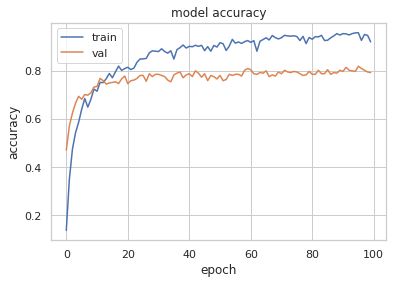

In [23]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

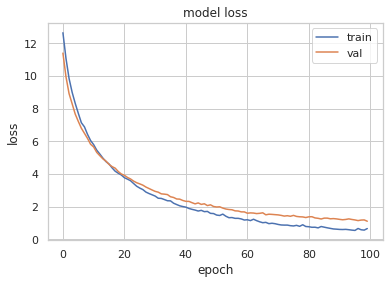

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [25]:
# Evaluating model on validation data
evaluate = model.evaluate(val_ds)
print(evaluate)

4/4 [==============================] - 1s 256ms/step - loss: 1.1154 - acc: 0.7933
[1.1154110431671143, 0.7932692170143127]


In [26]:
from sklearn.metrics import confusion_matrix


y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred,axis=1)
y_true = tf.concat([y for x, y in val_ds], axis=0)
con_mat = confusion_matrix(y_true, y_pred)

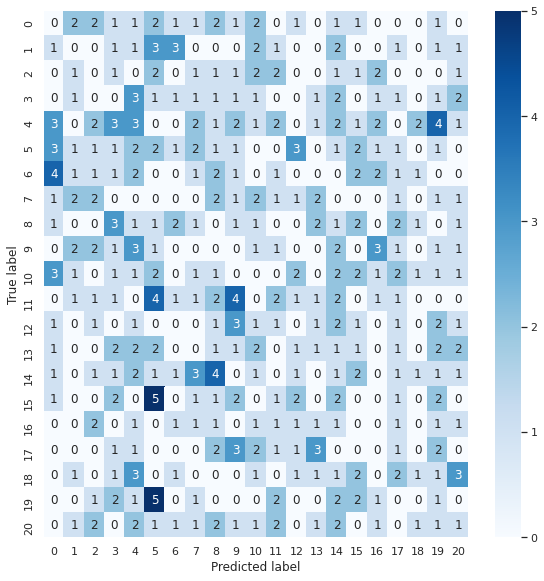

In [27]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Fine-tuning final model
It can be seen that with hyperparameter tuning the model was able to reach the 80% validation set accuracy needed, in the next section fine-tuning is applied as an extra step to see if we can even improve the model further.

In [28]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

Number of layers in the base model:  176


In [29]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [30]:
optimizer = keras.optimizers.Adam(lr=3e-4/10, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', 
                  metrics=['acc'],
                  optimizer=optimizer
             )

In [31]:
model.summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_37 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_181 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_144 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_182 (Dense)            (None, 512)               524

In [32]:
total_epochs = 110
history = model.fit(train_ds,epochs=total_epochs,validation_data=val_ds, initial_epoch=history.epoch[-1])

Epoch 100/110
14/14 [==============================] - 15s 804ms/step - loss: 0.5951 - acc: 0.9389 - val_loss: 1.2213 - val_acc: 0.7668
Epoch 101/110
14/14 [==============================] - 11s 712ms/step - loss: 0.5683 - acc: 0.9447 - val_loss: 1.2472 - val_acc: 0.7885
Epoch 102/110
14/14 [==============================] - 11s 716ms/step - loss: 0.5568 - acc: 0.9405 - val_loss: 1.2232 - val_acc: 0.7981
Epoch 103/110
14/14 [==============================] - 11s 711ms/step - loss: 0.5063 - acc: 0.9611 - val_loss: 1.2356 - val_acc: 0.8053
Epoch 104/110
14/14 [==============================] - 11s 712ms/step - loss: 0.4902 - acc: 0.9660 - val_loss: 1.2626 - val_acc: 0.8053
Epoch 105/110
14/14 [==============================] - 11s 713ms/step - loss: 0.5158 - acc: 0.9535 - val_loss: 1.2063 - val_acc: 0.8125
Epoch 106/110
14/14 [==============================] - 11s 715ms/step - loss: 0.4795 - acc: 0.9612 - val_loss: 1.2395 - val_acc: 0.8029
Epoch 107/110
14/14 [===========================

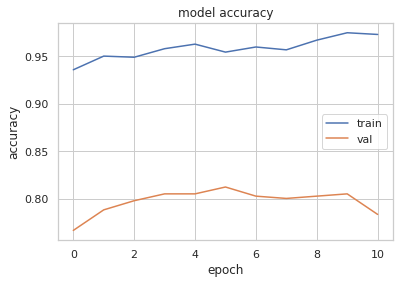

In [36]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

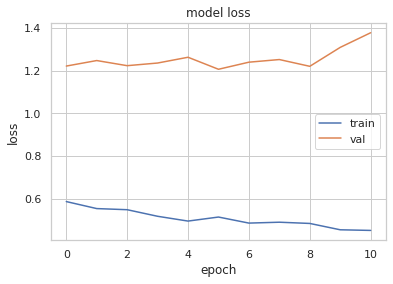

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [38]:
# Evaluating model on validation data
evaluate = model.evaluate(val_ds)
print(evaluate)

4/4 [==============================] - 1s 251ms/step - loss: 1.3774 - acc: 0.7837
[1.3773975372314453, 0.7836538553237915]


In [39]:
from sklearn.metrics import confusion_matrix


y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred,axis=1)
y_true = tf.concat([y for x, y in val_ds], axis=0)
con_mat = confusion_matrix(y_true, y_pred)

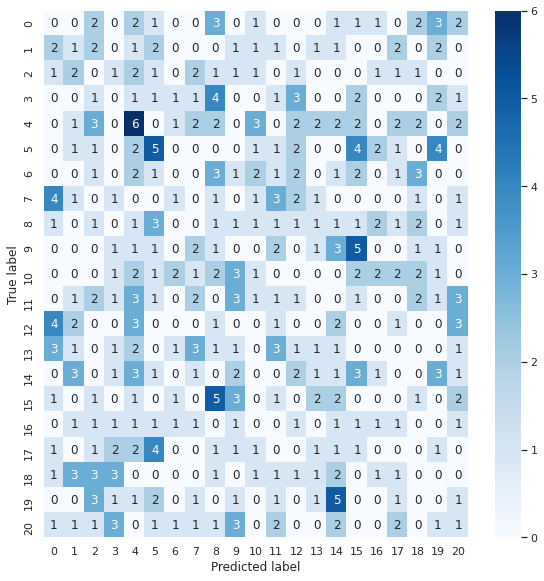

In [40]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Conclusion

A baseline model simply was trained with only 1 classification dense layer added after the freezed ResNet, then more complexity (layers) were added to this model and hyperparameter tuning was applied to find the best parameters for the final model, after finding a the best params the final model was trained then fine tuned to further improve the validation accuracy.

The confusion matrix shows the most misclassified classes, this could happen due to the fact that the training and validation data aren't big enough to create a better model so one improvement would be to increase the data used for both training and validation.